In [1]:
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa

from tqdm import tqdm_notebook as tqdm

In [2]:
n_mels = 80
fs = 44100
frame_length_ms=50
frame_shift_ms=25
nsc = int(fs * frame_length_ms / 1000)
nov = nsc - int(fs * frame_shift_ms / 1000)
nhop = int(fs * frame_shift_ms / 1000)
eps = 1e-8
db_ref = 160

meta_path = "D:/korean-single-speaker-speech-dataset/transcript.v.1.2.txt"
data_folder = "D:/korean-single-speaker-speech-dataset/kss"

with open(meta_path, encoding='utf-8') as f:
    metadata = np.array([line.strip().split('|') for line in f])
#     hours = sum((int(x[2]) for x in metadata)) * frame_shift_ms / (3600 * 1000)
#     log('Loaded metadata for %d examples (%.2f hours)' % (len(metadata), hours))

# metadata = metadata[:32, :2]

max_sequence_len = max(list(map(len, metadata[:, 1])))

error_jamos = [5868, 5998, 6046, 6155, 6202, 
               6654, 6890, 7486, 7502, 7744, 
               7765, 8267, 9069, 9927, 10437, 
               10515, 10533, 10606, 10610, 12777]

print(metadata.shape)
metadata = np.delete(metadata, error_jamos, axis = 0)
print(metadata.shape)

dataset_size = len(metadata)

(12853, 5)
(12833, 5)


In [3]:
character_length = list()
file_length = list()
division_length = list()
unicode_jamo_list = list()

for i in range(len(metadata)):
    character_length.append(len(metadata[i, 3]))
    file_length.append(float(metadata[i, 4]))
    division_length.append(float(metadata[i, 4]) * 1000 / len(metadata[i, 3]))

In [4]:
wave_name_list = []

for data in metadata:
    wave_name_list.append(data[0])

In [5]:
unicode_jamo_list = list()
for unicode in range(0x1100, 0x1113):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x1161, 0x1176):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x11A8, 0x11C3):
    unicode_jamo_list.append(chr(unicode))
    
unicode_jamo_list += [' ', '!', ',', '.', '?', '<sos>', '<eos>']
    
unicode_jamo_list.sort()

print(unicode_jamo_list)
print(len(unicode_jamo_list))

[' ', '!', ',', '.', '<eos>', '<sos>', '?', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ']
74


In [6]:
class Tokenizer():
    def __init__(self, vocabs):
        self.vocabs = vocabs
        
    def word2num(self, sentence):
        tokens = list()
        for char in sentence:
            tokens.append(self.vocabs.index(char))    
        return tokens
        
    def word2vec(self, sentence):
        vectors = np.zeros((len(sentence), len(self.vocabs)))
        for i, char in enumerate(sentence):
            vectors[i, self.vocabs.index(char)] = 1   
        return vectors
    
    def num2word(self, num):
        output = list()
        for i in num:
            output.append(self.vocabs[i])
        return output

In [7]:
tokenizer = Tokenizer(unicode_jamo_list)
jamo_tokens = tokenizer.word2num(unicode_jamo_list)

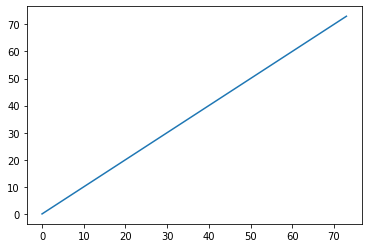

In [8]:
plt.plot(jamo_tokens)
plt.show()

In [10]:
mel_path_list = list()

for i, wav_name in enumerate(tqdm(wave_name_list)):
    
    npy_name = wav_name.replace('.wav', '.npy')
    wav_path = os.path.join(data_folder, wav_name)  
    mel_path = os.path.join(data_folder + '/mel', npy_name)
    mel_path_list.append(mel_path)
    
    if not os.path.isfile(mel_path):
#         print("{}".format(mel_path))
        y, sr = librosa.core.load(wav_path)
        f, t, Zxx = sp.signal.stft(y, fs=sr, nperseg=nsc, noverlap=nov)
        Sxx = np.abs(Zxx)
        Sxx = np.maximum(Sxx, eps)

        # plt.figure(figsize=(20,20))
        # plt.imshow(20*np.log10(Sxx), origin='lower')
        # plt.colorbar()
        # plt.show()

        mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=n_mels)
        mel_specgram = np.matmul(mel_filters, Sxx)

    #   log_specgram = 20*np.log10(Sxx)
    #   norm_log_specgram = (log_specgram + db_ref) / db_ref

        log_mel_specgram = 20 * np.log10(np.maximum(mel_specgram, eps))
        norm_log_mel_specgram = (log_mel_specgram + db_ref) / db_ref

    #   np.save(specgram_path, norm_log_specgram)
        np.save(mel_path, norm_log_mel_specgram)
    #   np.save(specgram_path, Sxx)

    #     print(norm_log_mel_specgram.shape[1])

    #     if i % 1000 == 0:
    #         plt.figure(figsize=(8, 4))
    #         plt.imshow(20 * np.log10(Sxx), origin='lower', aspect='auto')
    #         plt.colorbar()
    #         plt.show()

    #         plt.figure(figsize=(8, 4))
    #         plt.imshow(norm_log_mel_specgram, origin='lower', aspect='auto')
    #         plt.colorbar()
    #         plt.show()    

In [11]:
# embedding_layer = nn.Embedding(len(jamo_tokens), 256)

# print(metadata[5031, 3])
# print(metadata[5031, 2])
# print(len(metadata[5031, 3]))

# input_token = tokenizer.word2num(metadata[5031, 3])
# input_tensor = torch.tensor(input_token)
# plt.imshow(embedding_layer(input_tensor).detach().numpy())

In [12]:
class Encoder(nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Encoder, self).__init__()
        self.H = H
        self.fc = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        
        self.fc_2 = torch.nn.Linear(H, H)
        self.relu_2 = torch.nn.ReLU()
        
        self.gru = nn.GRU(H, D_out, num_layers=3, bidirectional=True)
        self.relu_gru = torch.nn.ReLU()

    def forward(self, input_tensor):
        output_tensor = self.fc(input_tensor)
        output_tensor = self.relu(output_tensor)
        
        output_tensor, _ = self.gru(output_tensor)
        output_tensor = self.relu_gru(output_tensor)
        
        output_tensor = self.fc_2(output_tensor)
        output_tensor = self.relu_2(output_tensor)
        return output_tensor
    
class Decoder(nn.Module):
    def __init__(self, H, D_out):
        super(Decoder, self).__init__()
        self.H = H
        self.fc_embed = nn.Linear(256, 1024)
        self.gru = nn.GRU(2 * H, H)
        self.attention = AttentionModule(D_out * 2)
        self.fc = nn.Linear(1024, 74)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, input_tensor, hidden_tensor, query):
        output_tensor = self.fc_embed(input_tensor)
        output_tensor, hidden_tensor = self.gru(output_tensor, hidden_tensor)
        context_vector = self.attention(query, output_tensor)
        output_tensor = torch.cat([output_tensor, context_vector], dim=2)
#         print('output_tensor: {}'.format(output_tensor.shape))
#         print('output_tensor: {}'.format(context_vector.shape))
        output_tensor = self.fc(output_tensor)
        prediction_tensor = self.softmax(output_tensor)

        return prediction_tensor, hidden_tensor, context_vector

class AttentionModule(torch.nn.Module):
    def __init__(self, H):
        super(AttentionModule, self).__init__()
        self.fc_alpha = nn.Linear(H, 1)
        self.W = nn.Linear(H, H)
        self.V = nn.Linear(H, H)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, query, key):
        output_tensor = torch.tanh(torch.add(self.W(query), self.V(key)))
        e = self.fc_alpha(output_tensor)
        e_sig = self.sigmoid(e)
        alpha = self.softmax(e_sig).transpose(1, 2)
        context_vector = torch.bmm(alpha, query)
        
        return context_vector

class Mel2SeqNet():
    def __init__(self, D_in, H, D_out):
        super(Mel2SeqNet, self).__init__()
        self.H = H
        self.encoder = Encoder(D_in, H, D_out) 
        self.embedding_layer = nn.Embedding(len(jamo_tokens), 256)
        self.decoder = Decoder(H, D_out)
        self.encoder_optimizer = optim.SGD(self.encoder.parameters(), lr=0.01)
        self.decoder_optimizer = optim.SGD(self.decoder.parameters(), lr=0.01)
        self.embedding_optimizer = optim.SGD(self.embedding_layer.parameters(), lr=0.01)
        
        self.criterion = nn.CrossEntropyLoss()

    def train(self, input_tensor, ground_truth):

        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()
        self.embedding_optimizer.zero_grad()

        encoded_tensor = self.encoder(input_tensor)
        decoder_hidden = encoded_tensor[:, -1, :].view(1, 1, self.H)
        
        pred_tensor_list = list()
        context_vector_list = list()
        
        loss = 0
        
        decoder_input = self.embedding_layer(torch.tensor(tokenizer.word2num(['<sos>']))).view([1, 1, -1])
        
        for i in range(len(ground_truth)):
            
            pred_tensor, decoder_hidden, context_vector = self.decoder(decoder_input, decoder_hidden, encoded_tensor)
            pred_tensor_list.append(pred_tensor)
            context_vector_list.append(context_vector)
            
            loss += self.criterion(pred_tensor.view([1, -1]), ground_truth[i].view(1))
            decoder_input = self.embedding_layer(ground_truth[i]).view([1, 1, -1])
            
        loss.backward()

        self.encoder_optimizer.step()
        self.decoder_optimizer.step()
        self.embedding_optimizer.step()

        pred_tensor = torch.cat(pred_tensor_list, dim=1)
        context_matrix = torch.cat(context_vector_list, dim=1)
        
        return pred_tensor, context_matrix, loss.item() / len(ground_truth)
    
    def save(self, check_point_name):
        torch.save({
            'embedding_layer_state_dict': self.embedding_layer.state_dict(),
            'encoder_state_dict': self.encoder.state_dict(),
            'decoder_state_dict': self.decoder.state_dict(),
            'embedding_optimizer_state_dict': self.embedding_optimizer.state_dict(),
            'encoder_optimizer_state_dict': self.encoder_optimizer.state_dict(),
            'decoder_optimizer_state_dict': self.decoder_optimizer.state_dict(),
            }, check_point_name)
    
    def load(self, check_point_name):
        checkpoint = torch.load(check_point_name)
        self.embedding_layer.load_state_dict(checkpoint['embedding_layer_state_dict'])
        self.encoder.load_state_dict(checkpoint['encoder_state_dict'])
        self.decoder.load_state_dict(checkpoint['decoder_state_dict'])
        self.embedding_optimizer.load_state_dict(checkpoint['embedding_optimizer_state_dict'])
        self.encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
        self.decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
    
        self.embedding_layer.eval()
        self.encoder.eval()
        self.decoder.eval()
    
net = Mel2SeqNet(80, 512, 256)

In [13]:
EPOCH = 1

for epoch in range(EPOCH):
    for i in tqdm(range(len(metadata))):
        norm_log_mel_specgram = np.load(mel_path_list[i])
        input_spectrogram = norm_log_mel_specgram.T
        tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
        ground_truth = torch.tensor(tokenizer.word2num(list(metadata[i, 3]) + ['<eos>']))

        pred_tensor, context_matrix, loss = net.train(tensor_input, ground_truth)
        
        if (i % 10 == 0):
            print('Loss {}: {}'.format(i, loss))

Loss 0: 4.304347991943359
Loss 10: 4.303143045176631
Loss 20: 4.302452087402344
Loss 30: 4.302085876464844
Loss 40: 4.302023397909628
Loss 50: 4.301064742238898
Loss 60: 4.299983433314732
Loss 70: 4.3025255705180925
Loss 80: 4.294474283854167
Loss 90: 4.29112663269043
Loss 100: 4.26954943068484
Loss 110: 4.26636474609375
Loss 120: 4.25541741507394
Loss 130: 4.223692950080423
Loss 140: 4.209004720052083
Loss 150: 4.1992978696469905
Loss 160: 4.0850168863932295
Loss 170: 4.1365113869691505
Loss 180: 4.199428947604432
Loss 190: 4.1050635049509445
Loss 200: 4.121079736826371
Loss 210: 4.100560701810396
Loss 220: 4.139442599549586
Loss 230: 4.073041915893555
Loss 240: 4.08807373046875
Loss 250: 4.082726218483665
Loss 260: 4.109728622436523
Loss 270: 4.1711476643880205
Loss 280: 4.1013389120296555
Loss 290: 4.063277859157986
Loss 300: 4.025575637817383
Loss 310: 4.046474729265485
Loss 320: 4.097513372247869
Loss 330: 4.010381525213068
Loss 340: 4.096340603298611
Loss 350: 4.035656553326231
L

KeyboardInterrupt: 

In [44]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [39]:
EPOCH = 1

for epoch in range(EPOCH):
    for i in tqdm(range(len(metadata))):
        norm_log_mel_specgram = np.load(mel_path_list[i])
        input_spectrogram = norm_log_mel_specgram.T
        tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
        ground_truth = torch.tensor(tokenizer.word2num(list(metadata[i, 3]) + ['<eos>']))

        pred_tensor, context_matrix, loss = net.train(tensor_input, ground_truth)
        
        if (i % 10 == 0):
            print('Loss {}: {}'.format(i, loss))

Loss 0: 4.035584767659505
Loss 10: 4.019740892493206
Loss 20: 3.981843619511045
Loss 30: 3.9866839599609376
Loss 40: 4.050534634976773


KeyboardInterrupt: 

In [38]:
net.save('check_point_test')

In [33]:
net.load('check_point_test')

In [34]:
tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])

ground_truth = torch.tensor(tokenizer.word2num(list(metadata[12832, 3]) + ['<eos>']))

pred_tensor, context_matrix, loss = net.train(tensor_input, ground_truth)

In [37]:
_, index = pred_tensor.max(-1)
# print(index.view(-1))
sentence = tokenizer.num2word(index.view(-1))
print(''.join(sentence))
print(metadata[5031, 2])

아  ᅡ 아아ᄋ아  아아ᄋ ᅡ 아ᄋ아ᄋ ᅡ ᅡ.<eos>
초현실주의 회화는 어떤 사람에게는 색과 모양을 마구잡이로 섞어 놓은 것처럼 보일 수 있다.
